Source: [github](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py?fbclid=IwAR1DeapNqcvNB4S9zTXlf6FkRaZGDBXd7M4EVUUGVawUkGZIO9Zu4eXac0M)

 ## Introduction

The mnist dataset provided in python is a dataset of 70 000 images of handwritten digits (possible labels: from 0 to 9).The dataset is devided into tranining 60 000 examples with their labels and 10 000 test examples with their lables as well. 
Each example is an image represented by a matrix of size an array of 784 elements (this is the flattened version of the 28x28 image).


### Importing libraries and the dataset

In [ ]:
import os
import numpy as np
import matplotlib as mpb
import matplotlib.pyplot as plt
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# to make the output of the notebook stable across runs
np.random.seed(42)

# resize the axis to get pretty figure
mpb.rc('axes', labelsize = 15)
mpb.rc('xtick', labelsize = 12)
mpb.rc('ytick', labelsize = 12)

# Import the MNIST dataset
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)
#mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

print(mnist.train.__class__)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>


In [ ]:
print(mnist.train.images.shape)
print(mnist.validation.images.shape)
print(mnist.test.images.shape)

(55000, 784)
(5000, 784)
(10000, 784)


If you have some difficulties you can check the link to the documentation provided. 


### Building the model 

We are going to define variables, placeholders...of the model 
as well as the architecture of the model before running it in a tensorflow session.


#### 1-Define X, y the input and the respective output of the model 

In [ ]:
X = tf.placeholder(tf.float32, shape =(None,784))

In this part we are going to define the different layers structure in the encoder and decoder part. We remind you that an the structure of autoencoder is symmetric. 
#### 2-Define the dimensions of the layers and the respective Weigths and biases of the model with given number of neurons in layers

In [ ]:
input_dim = 784
lay1_dim = 256
lay2_dim = 64  ### if 32 or 16, reconstructed image is not so good 
lay3_dim = 256
output_dim = 784

# encoder weights
Weight_encoder = tf.Variable(tf.random_normal(shape =(input_dim, lay1_dim)))
Weight_encoder1 = tf.Variable(tf.random_normal(shape =(lay1_dim, lay2_dim)))

# encoder biases 
bias_encoder = tf.Variable(tf.zeros(lay1_dim))
bias_encoder1 = tf.Variable(tf.zeros(lay2_dim))    

# decoder weights
Weight_decoder = tf.Variable(tf.random_normal(shape =(lay2_dim, lay3_dim), mean = 0, stddev = 0.5))
Weight_decoder1 = tf.Variable(tf.random_normal(shape =(lay3_dim, output_dim),mean = 0,  stddev = 0.5))

# decoder biases
bias_decoder = tf.Variable(tf.zeros(lay3_dim))          
bias_decoder1 = tf.Variable(tf.zeros(output_dim))

#### Hyperparameters
* Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.

* The batch size defines the number of samples that will be propagated through the network.

* An epoch is when an ENTIRE dataset is passed forwards and backwards through the neural network only ONCE.

You have to define the best hyperparameter that best optimize the model in other to reconstruct the image.
We look for a combination of hyperparameters which gives the best reocnstruction of the image in an acceptable execution time.
#### 3- Initialize the hyperparameters with some usual values.


In [ ]:
Learning_Rate = 0.01
num_epoch = 5
Batch_Size = 256

Building an Encoder and Decoder

An autoencoder is composed of two part:
* An encoder that convert the input to an internal representation: h = f(x).
* Decoder: that convert the internal representation to the outputs.

#### 4- Using the weights  and biases defined before, define the functions encode and decode


In [ ]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, Weight_encoder),bias_encoder))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, Weight_encoder1), bias_encoder1))
    return layer_2
    
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(x, Weight_decoder),tf.cast(bias_decoder, tf.float32)))
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, Weight_decoder1),tf.cast(bias_decoder1,tf.float32)))
    
    return layer_4

# Define model
Encoder = encoder(X)
Decoder = decoder(Encoder)

# prediction and target
X_true, X_pred = X, Decoder

# Loss
loss = tf.reduce_mean(tf.pow(X_true - X_pred, 2))
#train_step = tf.train.AdagradOptimizer(Learning_Rate).minimize(loss)
train_step = tf.train.RMSPropOptimizer(Learning_Rate).minimize(loss)

### Training the model 
The entire model already defined, we can now train it.

#### 5- Make the necessary changes and train the model. Afterwards, test it on the test dataset.


In [ ]:
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    print('Training...')
    for epoch in range(1, num_epoch):
        num_batch = mnist.train.num_examples//Batch_Size
        
        for batch in range(num_batch):
            #batch_x, batch_y = mnist.train.next_batch(Batch_Size)
            batch_x = mnist.train.images[np.arange(batch*Batch_Size, Batch_Size + batch*Batch_Size)]
            sess.run(train_step, feed_dict={X:batch_x})
        
        decoded_imgs = Decoder.eval({X: batch_x})
        feed_dict = {X_true: batch_x, X_pred: decoded_imgs}
        train_loss = loss.eval(feed_dict)
        print("epoch: {} | loss: {}".format(epoch,train_loss)) 
    
    decoded_imgs = Decoder.eval({X: mnist.test.images})
    #decoded_imgs = sess.run(Decoder, feed_dict={X: mnist.test.images})
    
    feed_dict = {X_true: mnist.test.images, X_pred: decoded_imgs}
    print('loss over test set:', loss.eval(feed_dict))


Training...
epoch: 1 | loss: 0.11702235788106918
epoch: 2 | loss: 0.055997736752033234
epoch: 3 | loss: 0.041531212627887726
epoch: 4 | loss: 0.03662145137786865
loss over test set: 0.037459064


In [ ]:
batch_x, batch_y = mnist.train.next_batch(0)
batch_x

array([], shape=(0, 784), dtype=float32)

In [ ]:
decoded_imgs.shape

(10000, 784)

In [ ]:
mnist.train.next_batch?


#### 6- Display the original and the reconstructed model for a few examples

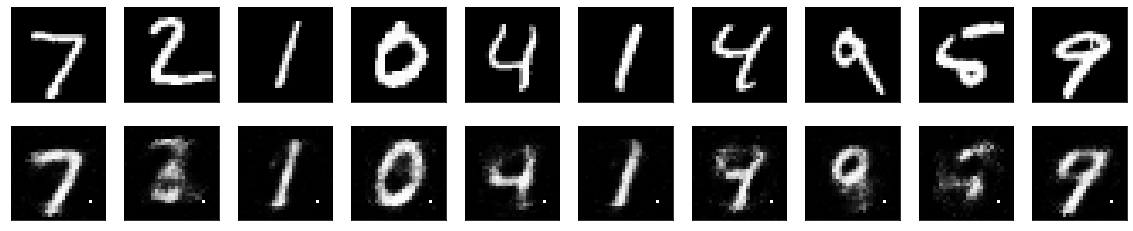

In [ ]:
examples_to_show = 10

x_test = mnist.test.images

plt.figure(figsize=(20, 4))
for i in range(examples_to_show):
    # display original
    ax = plt.subplot(2, examples_to_show, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, examples_to_show, i + 1 + examples_to_show)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


#### 7-Change the hyperparameter, the number of layer in other to reach better reconstructed images and display the result. Comment!

In [ ]:
# change the hyperparameters 

Learning_Rate = ...
num_epoch = ...
Batch_Size = ...

# train the model with the new hyperparameters
init = tf.initialize_all_variables()

with tf.Session() as sess:
    ...
    
# display some images and the corresponding reconstructed ones